In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import seaborn as sns
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [3]:
comp_dir = Path("../input/store-sales-time-series-forecasting")
sales_data = pd.read_csv(comp_dir / "train.csv", parse_dates = ['date'])
test_data = pd.read_csv(comp_dir/ "test.csv",parse_dates = ['date'])
sales_data

## Calendar for special days

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,)

store_sales['date'] = store_sales.date.dt.to_period('D')

# store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index() # MultiIndex

# replace above MultiIndex line with the following 2 lines in order to get missing Christmas days
# as some algorithms later require filled out MultiIndex (even if just zeros), including the missing Christmas days
# (see https://stackoverflow.com/questions/62437346/add-missing-date-index-in-a-multiindex-dataframe)
m_index = pd.MultiIndex.from_product([store_sales["store_nbr"].unique(),
                                      store_sales["family"].unique(),
                                      pd.date_range(start="2013-1-1", end="2017-8-15", freq="D").to_period('D')] # to get missing Christmas Days
                                     ,names=["store_nbr","family", "date"])
store_sales = store_sales.set_index(["store_nbr","family", "date"]).reindex(m_index, fill_value=0).sort_index()


store_sales = store_sales.unstack(['store_nbr', 'family']).fillna(0) # there are lots!
store_sales = store_sales.stack(['store_nbr', 'family'])
store_sales = store_sales[['sales','onpromotion']] # reorder columns to be in the expected order

store_sales

sales  onpromotion
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                     0.000000            0
                     BABY CARE                      0.000000            0
                     BEAUTY                         0.000000            0
                     BEVERAGES                      0.000000            0
                     BOOKS                          0.000000            0
...                                                      ...          ...
2017-08-15 9         POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

[3008016 rows x 2 columns]

In [5]:
store_sales_in_date_range = store_sales.unstack(['store_nbr', 'family']).loc['2015-01-01':'2017-08-15']
store_sales_in_date_range

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2015-01-02        2.0       0.0    3.0     794.0   0.0   285.627991   
2015-01-03        6.0       0.0    1.0     938.0   0.0   289.562988   
2015-01-04        4.0       0.0    0.0     574.0   0.0   151.744003   
2015-01-05        5.0       0.0    3.0    1299.0   0.0   457.542999   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2015-01-01         0.0      0.0    0.0    0.000000  ...           0     0   
2015-01-02         0.0    501.0  426.0   81.973999  ...           0     0   
2015-01-03         0.0    470.0  568.0   76.522003  ...           0     0   
2015-01-04         0.0    312.0  362.0   59.009998  ...           0     0   
2015-01-05         0.0   1047.0  814.0  163.789001  ...           0     1   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...           0     0   
2017-08-12         3.0    351.0  526.0   99.487999  ...           0     0   
2017-08-13         1.0    169.0  266.0   47.770000  ...           0     0   
2017-08-14         4.0    571.0  699.0  154.578003  ...           0     0   
2017-08-15        21.0    703.0  602.0  116.402000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2015-01-01             0            0                       0       0   
2015-01-02             0            0                       0       2   
2015-01-03             0            0                       0       2   
2015-01-04             0            0                       0       4   
2015-01-05             0            0                       0       3   
...                  ...          ...                     ...     ...   
2017-08-11            11            0                       0      22   
2017-08-12             7            0                       0       0   
2017-08-13             9            0                       0       0   
2017-08-14            10            0                       0       0   
2017-08-15            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2015-01-01              0       0                          0       0  
2015-01-02              0       0                          0       0  
2015-01-03              0       0                          0       0  
2015-01-04              0       0                          0       0  
2015-01-05              0       0                          0       0  
...                   ...     ...                        ..

In [6]:
#holiday = pd.read_csv(comp_dir / "holidays_events.csv", parse_dates = ['date'],
 #                                                       infer_datetime_format=True,)
holiday = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',},
    parse_dates=['date'],
    infer_datetime_format=True,)

holiday = holiday.set_index('date').to_period('D').sort_index() 
calendar = pd.DataFrame(index = pd.date_range('2015-01-01','2017-08-31')).to_period('D')
calendar['dofw'] = calendar.index.dayofweek

df_hev = holiday[holiday.locale == 'National']
df_hev = df_hev.groupby(df_hev.index).first() # Keep one event only

calendar["wd"] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

calendar

,dofw,wd,type,locale,locale_name,description,transferred
2015-01-01,3,False,Holiday,National,Ecuador,Primer dia del ano,False
2015-01-02,4,False,Bridge,National,Ecuador,Puente Primer dia del ano,False
2015-01-03,5,False,NaN,NaN,NaN,NaN,NaN
2015-01-04,6,False,NaN,NaN,NaN,NaN,NaN
2015-01-05,0,True,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-08-27,6,False,NaN,NaN,NaN,NaN,NaN
2017-08-28,0,True,NaN,NaN,NaN,NaN,NaN
2017-08-29,1,True,NaN,NaN,NaN,NaN,NaN
2017-08-30,2,True,NaN,NaN,NaN,NaN,NaN


In [7]:
calendar.tail(23)

,dofw,wd,type,locale,locale_name,description,transferred
2017-08-09,2,True,NaN,NaN,NaN,NaN,NaN
2017-08-10,3,True,Holiday,National,Ecuador,Primer Grito de Independencia,True
2017-08-11,4,False,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
2017-08-12,5,False,NaN,NaN,NaN,NaN,NaN
2017-08-13,6,False,NaN,NaN,NaN,NaN,NaN
2017-08-14,0,True,NaN,NaN,NaN,NaN,NaN
2017-08-15,1,True,NaN,NaN,NaN,NaN,NaN
2017-08-16,2,True,NaN,NaN,NaN,NaN,NaN
2017-08-17,3,True,NaN,NaN,NaN,NaN,NaN
2017-08-18,4,True,NaN,NaN,NaN,NaN,NaN


In [8]:
sales = (
    sales_data
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2015-01-01':'2017-08-15']
)
sales

id                                              \
family     AUTOMOTIVE  BABY CARE     BEAUTY  BEVERAGES      BOOKS   
date                                                                
2015-01-01  1298170.5  1298171.5  1298172.5  1298173.5  1298174.5   
2015-01-02  1299952.5  1299953.5  1299954.5  1299955.5  1299956.5   
2015-01-03  1301734.5  1301735.5  1301736.5  1301737.5  1301738.5   
2015-01-04  1303516.5  1303517.5  1303518.5  1303519.5  1303520.5   
2015-01-05  1305298.5  1305299.5  1305300.5  1305301.5  1305302.5   
...               ...        ...        ...        ...        ...   
2017-08-11  2992852.5  2992853.5  2992854.5  2992855.5  2992856.5   
2017-08-12  2994634.5  2994635.5  2994636.5  2994637.5  2994638.5   
2017-08-13  2996416.5  2996417.5  2996418.5  2996419.5  2996420.5   
2017-08-14  2998198.5  2998199.5  2998200.5  2998201.5  2998202.5   
2017-08-15  2999980.5  2999981.5  2999982.5  2999983.5  2999984.5   

                                                                      ...  \
family     BREAD/BAKERY CELEBRATION   CLEANING      DAIRY       DELI  ...   
date                                                                  ...   
2015-01-01    1298175.5   1298176.5  1298177.5  1298178.5  1298179.5  ...   
2015-01-02    1299957.5   1299958.5  1299959.5  1299960.5  1299961.5  ...   
2015-01-03    1301739.5   1301740.5  1301741.5  1301742.5  1301743.5  ...   
2015-01-04    1303521.5   1303522.5  1303523.5  1303524.5  1303525.5  ...   
2015-01-05    1305303.5   1305304.5  1305305.5  1305306.5  1305307.5  ...   
...                 ...         ...        ...        ...        ...  ...   
2017-08-11    2992857.5   2992858.5  2992859.5  2992860.5  2992861.5  ...   
2017-08-12    2994639.5   2994640.5  2994641.5  2994642.5  2994643.5  ...   
2017-08-13    2996421.5   2996422.5  2996423.5  2996424.5  2996425.5  ...   
2017-08-14    2998203.5   2998204.5  2998205.5  2998206.5  2998207.5  ...   
2017-08-15    2999985.5   2999986.5  2999987.5  2999988.5  2999989.5  ...   

           onpromotion                                        \
family       MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date                                                           
2015-01-01         0.0   0.037037      0.000000          0.0   
2015-01-02         0.0  18.407407      0.481481          0.0   
2015-01-03         0.0   0.574074      0.518519          0.0   
2015-01-04         0.0   0.870370      0.500000          0.0   
2015-01-05         0.0   0.685185      0.574074          0.0   
...                ...        ...           ...          ...   
2017-08-11         0.0  22.925926      9.000000          0.0   
2017-08-12         0.0   0.000000      8.703704          0.0   
2017-08-13         0.0   0.000000      9.240741          0.0   
2017-08-14         0.0   0.000000      8.722222          0.0   
2017-08-15         0.0   0.000000      8.814815          0.0   

                                                                         \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS    PRODUCE   
date                                                                      
2015-01-01                0.000000   0.000000       0.000000   0.000000   
2015-01-02                0.000000  14.518519       0.481481   0.000000   
2015-01-03                0.000000   1.537037       0.018519   0.000000   
2015-01-04                0.000000   1.370370       0.018519   0.000000   
2015-01-05                0.000000   1.074074       0.055556   0.000000   
...                            ...        ...            ...        ...   
2017-08-11                0.000000  27.407407       0.537037   6.000000   
2017-08-12                0.018519   0.111111       0.277778   6.000000   
2017-08-13                0.000000   0.185185       0.222222   5.907407   
2017-08-14                0.000000   0.129630       0.148148   6.018519   
2017-08-15                0.092593   0.111111       0.166667  58.685185   

                         

In [9]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [10]:
sales_data['date'] = sales_data.date.dt.to_period('D')
sales_data = sales_data.set_index(['store_nbr', 'family', 'date']).sort_index()
avg_sales = (
    sales_data
    .groupby( 'date')
    .mean()
    .squeeze()
    .loc['2016']
)


In [11]:
avg_sales

,id,sales,onpromotion
date,,,
2016-01-01,1946834.5,9.221882,0.089226
2016-01-02,1948616.5,598.584414,1.028058
2016-01-03,1950398.5,688.403883,1.647587
2016-01-04,1952180.5,536.451670,0.976992
2016-01-05,1953962.5,468.754455,2.216611
...,...,...,...
2016-12-27,2588354.5,472.769635,9.061167
2016-12-28,2590136.5,533.969536,13.262626
2016-12-29,2591918.5,501.744241,8.909652


In [12]:
sales.head()

id                                              \
family     AUTOMOTIVE  BABY CARE     BEAUTY  BEVERAGES      BOOKS   
date                                                                
2015-01-01  1298170.5  1298171.5  1298172.5  1298173.5  1298174.5   
2015-01-02  1299952.5  1299953.5  1299954.5  1299955.5  1299956.5   
2015-01-03  1301734.5  1301735.5  1301736.5  1301737.5  1301738.5   
2015-01-04  1303516.5  1303517.5  1303518.5  1303519.5  1303520.5   
2015-01-05  1305298.5  1305299.5  1305300.5  1305301.5  1305302.5   

                                                                      ...  \
family     BREAD/BAKERY CELEBRATION   CLEANING      DAIRY       DELI  ...   
date                                                                  ...   
2015-01-01    1298175.5   1298176.5  1298177.5  1298178.5  1298179.5  ...   
2015-01-02    1299957.5   1299958.5  1299959.5  1299960.5  1299961.5  ...   
2015-01-03    1301739.5   1301740.5  1301741.5  1301742.5  1301743.5  ...   
2015-01-04    1303521.5   1303522.5  1303523.5  1303524.5  1303525.5  ...   
2015-01-05    1305303.5   1305304.5  1305305.5  1305306.5  1305307.5  ...   

           onpromotion                                        \
family       MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date                                                           
2015-01-01         0.0   0.037037      0.000000          0.0   
2015-01-02         0.0  18.407407      0.481481          0.0   
2015-01-03         0.0   0.574074      0.518519          0.0   
2015-01-04         0.0   0.870370      0.500000          0.0   
2015-01-05         0.0   0.685185      0.574074          0.0   

                                                                      \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS PRODUCE   
date                                                                   
2015-01-01                     0.0   0.000000       0.000000     0.0   
2015-01-02                     0.0  14.518519       0.481481     0.0   
2015-01-03                     0.0   1.537037       0.018519     0.0   
2015-01-04                     0.0   1.370370       0.018519     0.0   
2015-01-05                     0.0   1.074074       0.055556     0.0   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2015-01-01                        0.0  0.000000  
2015-01-02                        0.0  2.611111  
2015-01-03                        0.0  0.018519  
2015-01-04                        0.0  0.018519  
2015-01-05                        0.0  0.037037  

[5 rows x 132 columns]

## Seasonality

Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  import sys


<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

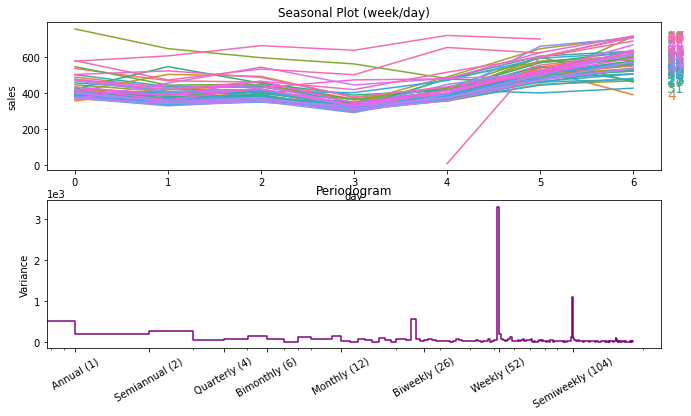

In [13]:
# days within a week
X = avg_sales.copy()
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax= ax0)
plot_periodogram(avg_sales.sales,ax = ax1)


Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

In [14]:
class BoostedHybrid:
    def __init__(self, model_1,model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.y_resid = None
        
    def fit(self,X_1, X_2, y):
        self.model_1.fit(X_1,y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),  # make predictions with self.model_1
            index=X_1.index, columns=y.columns,
        )
        self.y_resid = y - y_fit  # compute residuals which X_2 may need
        self.y_resid = self.y_resid.stack(['store_nbr', 'family']).squeeze() # wide to long
    
        self.model_2.fit(X_2, self.y_resid) # fit self.model_2 on residuals
        self.y_columns = y.columns # Save column names for predict method
   
    def predict(self, X_1, X_2) :
        y_pred = pd.DataFrame(
                self.model_1.predict(X_1),
                index = X_1.index, columns = self.y_columns,
            )
        y_pred = y_pred.stack(['store_nbr', 'family']).squeeze()  # wide to long
        y_pred += self.model_2.predict(X_2)   # add self.model_2 predictions to y_pred
        return y_pred.unstack(['store_nbr', 'family'])  # long to wide


In [15]:
# Target series
#y = sales.loc[:, 'sales']

y = store_sales_in_date_range.loc[:, 'sales']
# X_1: Features for Linear Regression
#Use 
fourier = CalendarFourier(freq = 'M',order = 4)
dp = DeterministicProcess(
        index=y.index,
        constant = True,
        order=1,
        seasonal  = True,
        additional_terms = [fourier],
        drop = True,
)
X_1 = dp.in_sample()

X_1['NewYear'] = (X_1.index.dayofyear == 1)
X_1['Christmas'] = (X_1.index=='2016-12-25') | (X_1.index=='2015-12-25') | (X_1.index=='2014-12-25') | (X_1.index=='2013-12-25')
X_1['wd']   = calendar.loc['2015-01-01':'2017-08-15']['wd'].values
#X_1['type'] = calendar.loc['2015-01-01':'2017-08-15']['type'].values
#X_1 = pd.get_dummies(X_1, columns=['type'], drop_first=False)
X_1



,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear,Christmas,wd
date,,,,,,,,,,,,,,,,,,,
2015-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True,False,False
2015-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False,False,False
2015-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False,False,False
2015-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False,False,False
2015-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,954.0,1.0,0.0,0.0,0.0,0.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653,False,False,False
2017-08-12,1.0,955.0,0.0,1.0,0.0,0.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347,False,False,False
2017-08-13,1.0,956.0,0.0,0.0,1.0,0.0,0.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139,False,False,False


In [16]:
columns = ['store_nbr', 'family']
# X_2: Features for XGBoost
X_2 = store_sales_in_date_range.drop('sales', axis=1).stack(columns)  # onpromotion feature

# Label encoding for 'family'

le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index(columns)
for col in columns:
    X_2[col] = le.fit_transform(X_2[col])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month
X_2.tail()

,store_nbr,family,onpromotion,day
date,,,,
2017-08-15,53,28,0,15
2017-08-15,53,29,1,15
2017-08-15,53,30,148,15
2017-08-15,53,31,8,15
2017-08-15,53,32,0,15


In [17]:
model = BoostedHybrid(LinearRegression() , XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1,X_2)

y_pred = y_pred.clip(0.0)



In [18]:
y_train, y_valid = y[:"2017-08-01"], y["2017-08-02":]
X1_train, X1_valid = X_1[: "2017-08-01"], X_1["2017-08-02" :]
X2_train, X2_valid = X_2.loc[:"2017-08-01"], X_2.loc["2017-08-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)



In [19]:
y["2017-08-02":"2017-08-03"]

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-02        4.0       0.0    2.0    2645.0   0.0   428.186005   
2017-08-03        3.0       0.0    5.0    2037.0   0.0   282.809998   

store_nbr                                           ...         9              \
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2017-08-02         7.0    942.0  941.0  150.744995  ...       2.0  345.009003   
2017-08-03        10.0    622.0  529.0  106.929001  ...       3.0  559.057983   

store_nbr                                                                  \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2017-08-02         556.0         12.0                    10.0  455.652985   
2017-08-03         533.0         10.0                    11.0  425.946014   

store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2017-08-02      89.135002  1333.885010                      149.0  24.688999  
2017-08-03      83.426003  1364.578003                      139.0  21.778000  

[2 rows x 1782 columns]

In [20]:
y_pred["2017-08-02":"2017-08-03"]

store_nbr           1                                                          \
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-08-02   4.807967       0.0  3.900559  2909.082508  3.345580   468.077716   
2017-08-03   3.942498       0.0  5.085247  2507.982086  2.650204   376.960394   

store_nbr                                                   ...         9  \
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-08-02   23.386726  927.504296  963.998978  145.785162  ...  1.985296   
2017-08-03   23.086692  757.664179  761.854521  102.419017  ...  1.299912   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-08-02  442.506948    637.127071     7.277504               11.255319   
2017-08-03  599.326583    601.351983     6.187327               11.705911   

store_nbr                                                                      \
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-08-02  463.759255     133.487955  1858.877727                  49.606632   
2017-08-03  493.781937     126.590372  1818.896623                  10.709221   

store_nbr             
family       SEAFOOD  
date                  
2017-08-02  16.57790  
2017-08-03  17.04112  

[2 rows x 1782 columns]

In [21]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 1.03535
Validation RMSLE: 0.70765


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


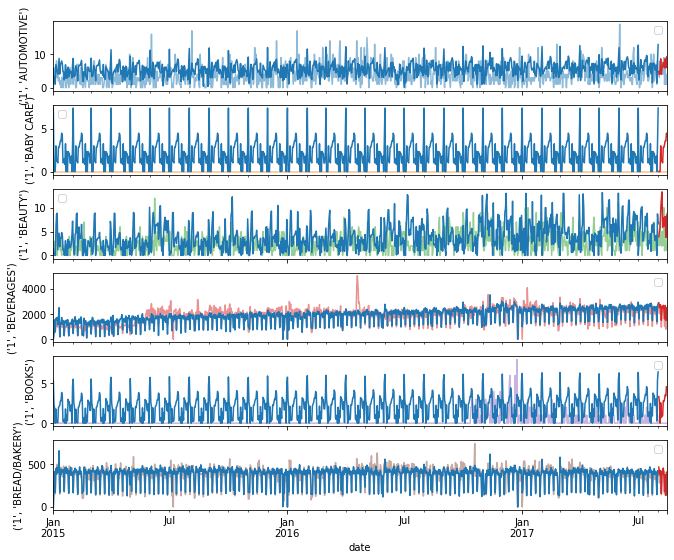

In [22]:
families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)